<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-exploration" data-toc-modified-id="Data-exploration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data exploration</a></span></li><li><span><a href="#XGBoost-model" data-toc-modified-id="XGBoost-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>XGBoost model</a></span><ul class="toc-item"><li><span><a href="#Hyperparameter-tuning-with-Hyperopt" data-toc-modified-id="Hyperparameter-tuning-with-Hyperopt-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Hyperparameter tuning with Hyperopt</a></span></li><li><span><a href="#Model-fitting" data-toc-modified-id="Model-fitting-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Model fitting</a></span></li></ul></li><li><span><a href="#Saving-the-model" data-toc-modified-id="Saving-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Saving the model</a></span></li><li><span><a href="#SHAP-values" data-toc-modified-id="SHAP-values-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SHAP values</a></span></li><li><span><a href="#Fitting-additional-logistic-regression" data-toc-modified-id="Fitting-additional-logistic-regression-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Fitting additional logistic regression</a></span></li><li><span><a href="#Validation-check" data-toc-modified-id="Validation-check-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Validation check</a></span></li><li><span><a href="#Scoring-the-test-set-and-submitting" data-toc-modified-id="Scoring-the-test-set-and-submitting-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Scoring the test set and submitting</a></span></li></ul></div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import random
import mofr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_tree
import math
import pickle
import statsmodels.api as sm


import xgboost as xgb

In [3]:
seed=1234

In [4]:
# file = open("type2id.pkl",'rb')
# object_file = pickle.load(file)

In [5]:
file_name = "aid_model.pkl"

In [6]:
df=pd.read_parquet('aid_analysis_base.parquet')

In [7]:
df.columns=[x.lower() for x in df.columns]

In [8]:
df=df[df['visible']==0]

In [9]:
# sessions_with_orders=pd.DataFrame(df.groupby('session_id')['target'].sum()).reset_index()
# sessions_with_orders=sessions_with_orders[sessions_with_orders['target']>0]
# df=df.merge(sessions_with_orders['session_id'], how='inner', on='session_id')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 978235 entries, 0 to 1707211
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   target                     978235 non-null  float64
 1   session_id                 978235 non-null  float64
 2   aid                        978235 non-null  float64
 3   ts                         978235 non-null  float64
 4   day_of_week                978235 non-null  float64
 5   cart_order                 978235 non-null  float64
 6   visible                    978235 non-null  float64
 7   in_session                 978235 non-null  float64
 8   in_candidates              978235 non-null  float64
 9   in_valid                   978235 non-null  float64
 10  num_clicks_same_day        954432 non-null  float64
 11  num_carts_same_day         954432 non-null  float64
 12  num_orders_same_day        954432 non-null  float64
 13  first_seen                 9

In [11]:
df.head()

,target,session_id,aid,ts,day_of_week,cart_order,visible,in_session,in_candidates,in_valid,...,sess_num_clicks,sess_num_carts,sess_num_orders,sess_num_clicks_last_hour,sess_num_carts_last_hour,sess_num_orders_last_hour,sess_duration,sess_days_till_test,sess_minute,sess_hour
0,1.0,12701195.0,1699862.0,1.661686e+12,0.0,1.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.646667,0.458232,0.0,13.0
1,1.0,12860925.0,1079817.0,1.661715e+12,0.0,1.0,0.0,0.0,0.0,1.0,...,5.0,3.0,0.0,5.0,3.0,0.0,0.086111,0.113406,16.0,21.0
2,1.0,11823605.0,1068942.0,1.661358e+12,3.0,1.0,0.0,0.0,0.0,1.0,...,11.0,0.0,0.0,0.0,0.0,0.0,0.367222,4.244112,8.0,18.0
3,1.0,12839049.0,1529903.0,1.661712e+12,0.0,1.0,0.0,0.0,0.0,1.0,...,15.0,7.0,0.0,0.0,0.0,0.0,0.152222,0.159506,10.0,20.0
4,1.0,12626777.0,341632.0,1.661683e+12,0.0,1.0,0.0,0.0,0.0,1.0,...,3.0,2.0,0.0,0.0,0.0,0.0,0.024444,0.942827,22.0,1.0


In [12]:
train_mask=df['day_of_week']>-1
valid_mask=df['day_of_week']>-1

In [13]:
df[train_mask]['target'].value_counts()

0.0    599421
1.0    378814
Name: target, dtype: int64

In [14]:
df[train_mask]['target'].value_counts(normalize=True)

0.0    0.612758
1.0    0.387242
Name: target, dtype: float64

In [15]:
col_target='target'
col_exclude=[
'session_id',
'aid',
'ts',
'cart_order',
'in_candidates',
'in_session',
col_target,]

In [16]:
# df[col_target]=df[col_target].apply(int)

# Data exploration

In [17]:
col_preds=[col for col in df.columns[3:] if col not in col_exclude]

In [18]:
len(col_preds)

25

In [19]:
col_preds

['day_of_week',
 'visible',
 'in_valid',
 'num_clicks_same_day',
 'num_carts_same_day',
 'num_orders_same_day',
 'first_seen',
 'avg_seen',
 'last_seen',
 'first_bought',
 'avg_bought',
 'last_bought',
 'seen_overall',
 'bought_overall',
 'sess_num_events',
 'sess_num_clicks',
 'sess_num_carts',
 'sess_num_orders',
 'sess_num_clicks_last_hour',
 'sess_num_carts_last_hour',
 'sess_num_orders_last_hour',
 'sess_duration',
 'sess_days_till_test',
 'sess_minute',
 'sess_hour']

In [20]:
# df=df.apply(pd.to_numeric)

In [21]:
# for col in col_preds:
#     df[col]=df[col].fillna(-1000).apply(float)

In [22]:
# df.to_parquet('train_sample_trimmed_4weeks_float.parquet')

# XGBoost model

## Model fitting

In [23]:
train=df[train_mask]
print(train['session_id'].max())
train[col_target].value_counts()

12899739.0


0.0    599421
1.0    378814
Name: target, dtype: int64

In [24]:
xgb_model = XGBClassifier(max_depth=4, seed=seed, colsample_bytree=0.5, gamma=1, min_child_weight=5, n_estimators=100)
xgb_model.fit(train.loc[:, col_preds], train[col_target], verbose=0, eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1234, ...)

In [25]:
df['XGB_SCORE']=xgb_model.predict_proba(df[col_preds])[:, 1]
train['XGB_SCORE']=xgb_model.predict_proba(train[col_preds])[:, 1]

In [26]:
print('The Lift on the train set is: '+ str(mofr.metrics.lift(train[col_target], train['XGB_SCORE'])))
print('The gini on the train set is: '+ str(mofr.metrics.gini(train[col_target].apply(int), train['XGB_SCORE'])))
print('The accuracy on the train set is: '+ str(mofr.metrics.accuracy_score(train[col_target].apply(int), train['XGB_SCORE'].apply(lambda x: int(x>0.5)))))
print('\n')
print('The Lift on the valid set is: '+ str(mofr.metrics.lift(df[valid_mask][col_target], df[valid_mask]['XGB_SCORE'])))
print('The gini on the valid set is: '+ str(mofr.metrics.gini(df[valid_mask][col_target].apply(int), df[valid_mask]['XGB_SCORE'])))
print('The accuracy on the valid set is: '+ str(mofr.metrics.accuracy_score(df[valid_mask][col_target].apply(int), df[valid_mask]['XGB_SCORE'].apply(lambda x: int(x>0.5)))))
print('\n')

The Lift on the train set is: 2.1845173893044842
The gini on the train set is: 0.529868502107069
The accuracy on the train set is: 0.7176516890113316


The Lift on the valid set is: 2.1845173893044842
The gini on the valid set is: 0.529868502107069
The accuracy on the valid set is: 0.7176516890113316




In [27]:
# top20=df[(valid_mask)].groupby('session_id').apply(lambda x : x.sort_values(by = 'XGB_SCORE', ascending = False).head(20).reset_index(drop = True)).reset_index(drop = True)
# precision=pd.DataFrame(top20.groupby('session_id')[col_target].apply(np.mean)).rename(columns={ col_target:'PRECISION'}).reset_index()
# mean_precision=np.mean(precision['PRECISION'])
# print(f'The mean precision on valid set is: {mean_precision}')

In [28]:
# recall=pd.DataFrame(top20.groupby('session_id')[col_target].apply(np.sum)).merge(df[(valid_mask)][[col_target,'session_id']].groupby('session_id')[col_target].apply(np.sum), how='inner', on='session_id')
# mean_recall=np.mean(recall[recall['target_y']>0]['target_x']/recall[recall['target_y']>0]['target_y'])
# print(f'The mean recall on valid set is: {mean_recall}')

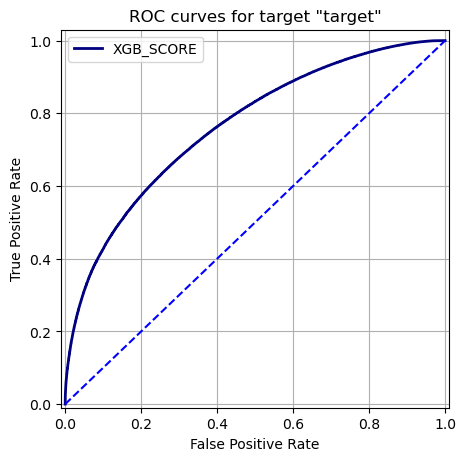

In [29]:
from mofr.basic_evaluators.ROCCurve import ROCCurveEvaluator
df['one']=1

rce=ROCCurveEvaluator()
rce.d(df[valid_mask]).t([(col_target,'one')]).s(['XGB_SCORE'])
rce.get_graph()

del df['one']

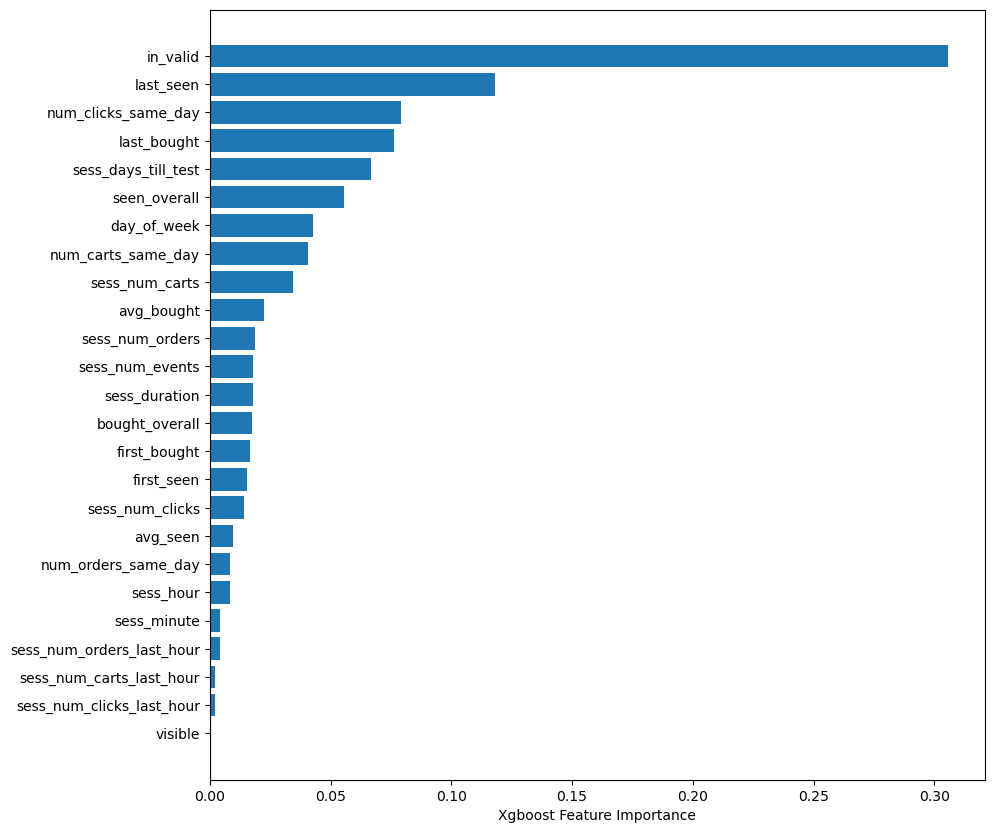

In [30]:
sorted_idx = xgb_model.feature_importances_.argsort()
order_ = []
for i in sorted_idx:
  order_.append(xgb_model.feature_names_in_[i])
plt.figure(figsize=(10, 10))
fig = plt.barh(order_, xgb_model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

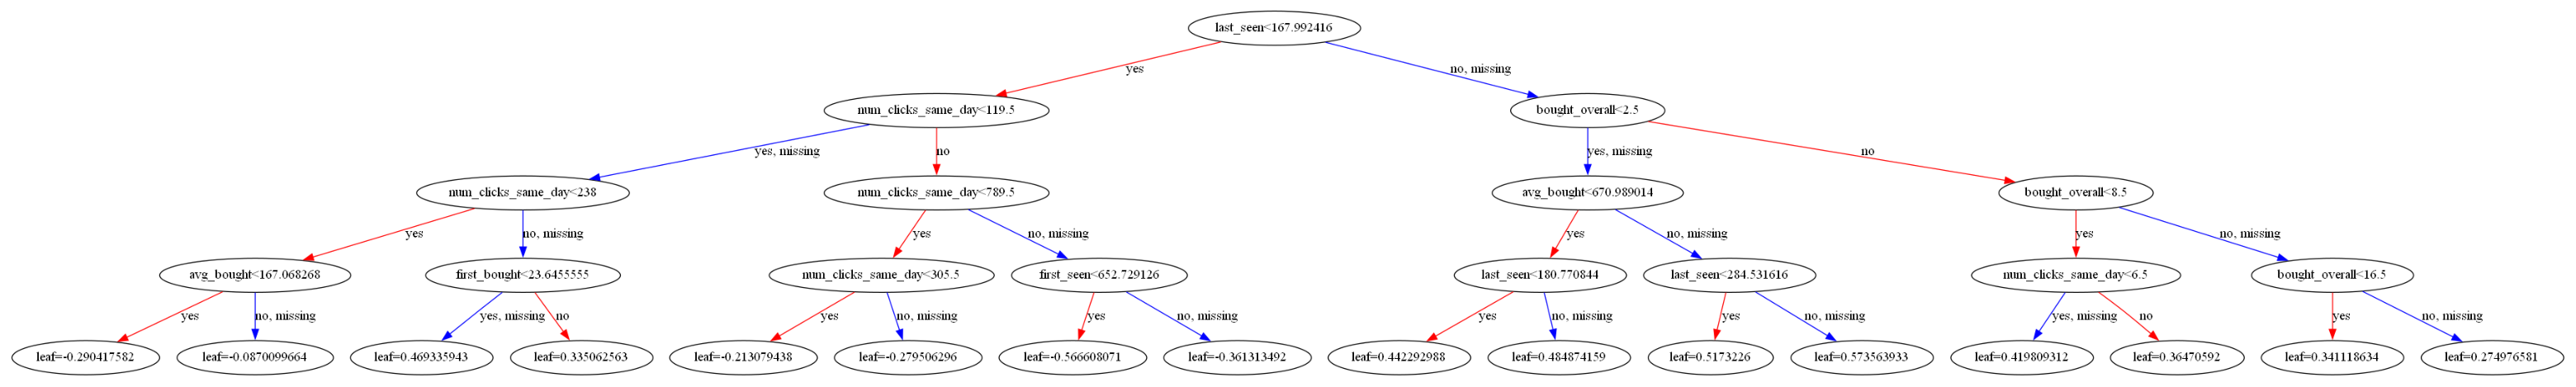

In [31]:
import os
os.environ["PATH"] += os.pathsep + 'c:/Program Files/Graphviz/bin/'

from xgboost import plot_tree
plt.rcParams["figure.figsize"] = (40,40)
plot_tree(xgb_model)
plt.show()

In [32]:
results=[]
for col in col_preds:
    results.append((col, np.abs(mofr.metrics.gini(df[valid_mask][col_target], df[valid_mask][col].fillna(0)))))
  
pd.DataFrame(results, columns=['Predictor', 'GINI']).sort_values(by='GINI', ascending=False)[0:30]

,Predictor,GINI
3,num_clicks_same_day,0.301781
12,seen_overall,0.294445
4,num_carts_same_day,0.281115
13,bought_overall,0.267046
8,last_seen,0.226306
5,num_orders_same_day,0.191129
6,first_seen,0.188268
9,first_bought,0.170295
11,last_bought,0.155761
2,in_valid,0.102040


# Saving the model

In [33]:
#file_name = "otto_xgb_model_10_3weeks_no_nulls.pkl"

# save
pickle.dump(xgb_model, open(file_name, "wb"))

# # load
# #xgb_model= pickle.load(open(file_name, "rb"))

# SHAP values

In [34]:
import shap  # package used to calculate Shap values
row_to_show = 1
data_for_prediction = train[col_preds].iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(xgb_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction_array)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

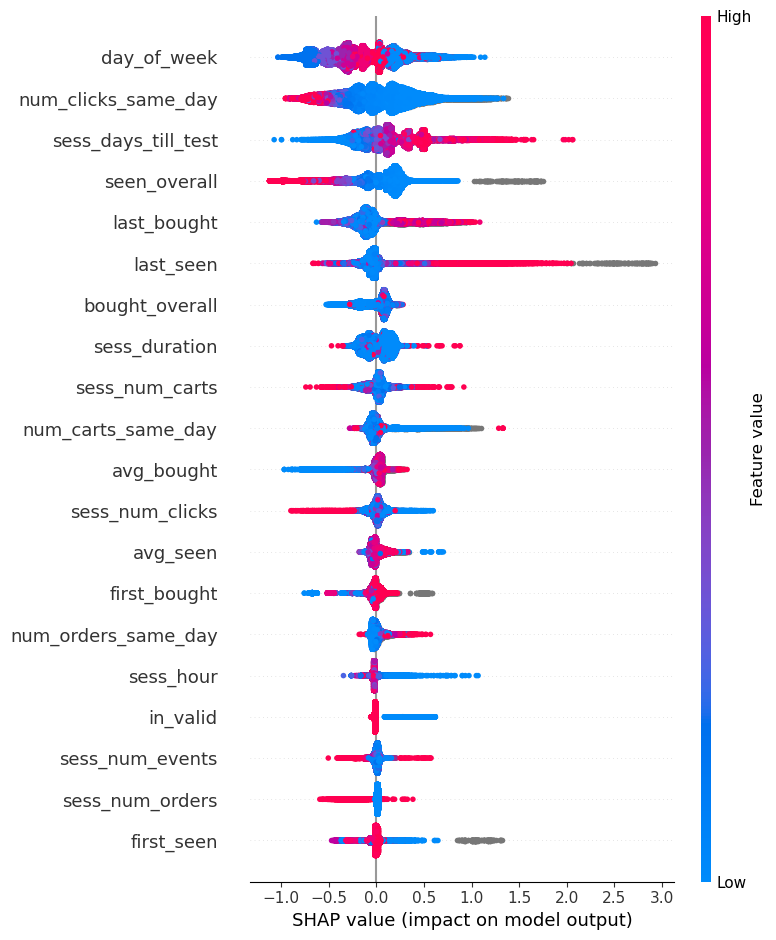

In [35]:
sample=train[col_preds].sample(100000)
shap_values = explainer.shap_values(sample)
shap.summary_plot(shap_values, sample[col_preds])
del sample